In [14]:
import hist
import boost_histogram as bh
import numpy as np
import mplhep as hep
import matplotlib.pyplot as plt
from utilities import boostHistHelpers as hh
from wremnants import histselections as sel
from wremnants import datasets2016
from wremnants import plot_tools
import wremnants
import h5py
import uproot
import narf
hep.style.use(hep.style.ROOT)

In [ ]:
with h5py.File("../mw_with_mu_eta_pt.hdf5", "r") as f:
    result = narf.ioutils.pickle_load_h5py(f["results"])
    print(result['WminustaunuPostVFP']['event_count'])
    print(result.keys())


dict_keys(['mTStudyForFakes', 'mtIsoJetCharge', 'MET', 'transverseMass', 'nominal_qcdJetPt30', 'nominal', 'nominal_weight', 'nominal_recoilUnc_source_para', 'nominal_recoilUnc_source_perp', 'nominal_recoilUnc_target_para', 'nominal_recoilUnc_target_para_bkg', 'nominal_recoilUnc_target_perp', 'nominal_recoilUnc_target_perp_bkg', 'nominal_uncorr', 'weight_uncorr', 'nominal_scetlib_dyturboCorr', 'nominal_gen', 'nominal_gen_smeared', 'nominal_effStatTnP_sf_reco', 'nominal_effStatTnP_sf_tracking', 'nominal_effStatTnP_sf_idip', 'nominal_effStatTnP_sf_trigger', 'nominal_effStatTnP_sf_iso_effData', 'nominal_effStatTnP_sf_iso_effMC', 'nominal_effSystTnP', 'nominal_muonL1PrefireStat', 'nominal_muonL1PrefireSyst', 'nominal_ecalL1Prefire', 'nominal_luminosity', 'nominal_pdfMSHT20', 'nominal_pdfMSHT20alphaS002', 'nominal_qcdScale', 'nominal_qcdScaleByHelicity', 'nominal_massWeight', 'nominal_muonScaleSyst', 'nominal_muonScaleSyst_gen_smear', 'nominal_muonScaleSystPerSeDown', 'nominal_muonScaleSystP

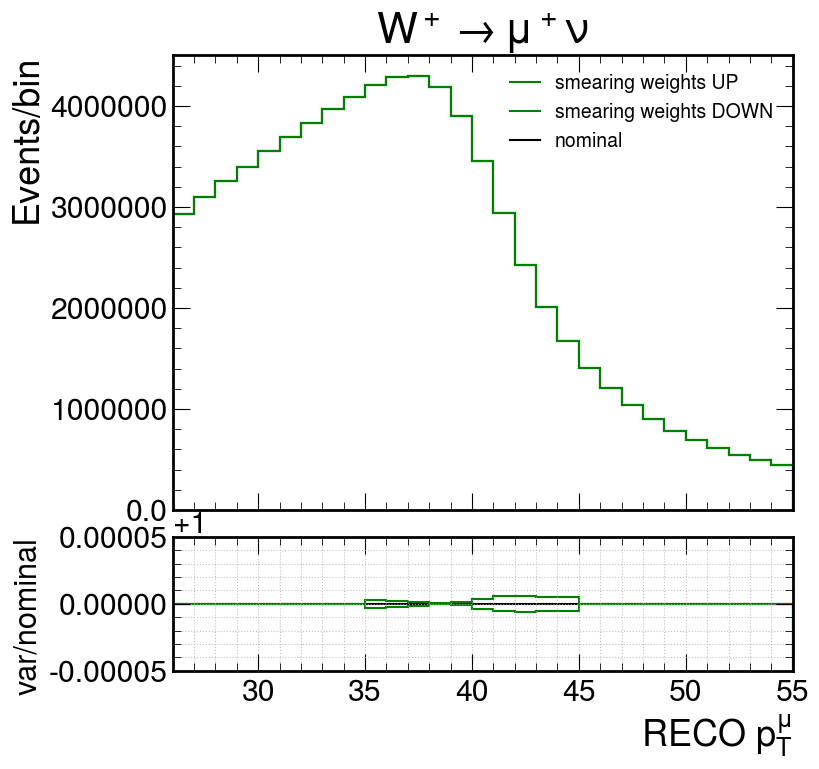

In [20]:
f = h5py.File("../mw_with_mu_eta_pt_scetlib_dyturboCorr.hdf5", "r")
results = narf.ioutils.pickle_load_h5py(f["results"])

proc = 'WplusmunuPostVFP'
proc_name_latex = {
    'WplusmunuPostVFP': r'$W^+ \rightarrow \mu^+ \nu$',
    'WminusmunuPostVFP': r'$W^- \rightarrow \mu^- \nu$',
}
print(results[proc]['output'].keys())

nuisances = [
    'muonScaleSyst_responseWeights',
    'Z_non_closure_parametrized',
    'Z_non_closure_parametrized_A',
    'Z_non_closure_parametrized_M',
    'Z_non_closure_binned'
]
hists = {}
hists['nominal'] = results[proc]['output']['nominal'].get()
hists['nominal_gensmear'] = results[proc]['output']['nominal_gen_smeared'].get()
for nuisance in nuisances:
    hists[nuisance + '_gensmear'] = results[proc]['output'][nuisance + '_gensmear'].get()
    hists['nominal_' + nuisance] = results[proc]['output']['nominal_' + nuisance].get()

action = lambda x: x.project('pt')

fig = plot_tools.makePlotWithRatioToRef(
    [
        action(hists['nominal']),
        action(hists['nominal_Z_non_closure_binned'][...,11,1,0]),
        action(hists['nominal_Z_non_closure_binned'][...,11,1,1])
    ],
    labels = [
        'nominal', 
        'smearing weights DOWN',
        'smearing weights UP'
    ],
    colors = ['black', 'green', 'green'],
    rrange = [0.99995, 1.00005],
    nlegcols = 1,
    rlabel = 'var/nominal',
    xlabel = r'RECO $p_T^{\mu}$',
    plot_title = proc_name_latex[proc],
    grid = True
)
#hists['nominal_Z_non_closure_parametrized'].values()

In [ ]:
import uproot
import hist
import numpy as np
from wremnants import muon_validation

n_scale_params = 3
n_tot_params = 4
n_eta_bins = 24
filepath = "../wremnants/data/calibration/calibrationJDATA_smeared_v718.root"

f = uproot.open(filepath)
cov = f['covariance_matrix'].to_hist()
cov_scale_params = muon_validation.get_jpsi_scale_param_cov_mat(cov, n_scale_params, n_tot_params, n_eta_bins)

w,v = np.linalg.eigh(cov_scale_params)
var_mat = np.sqrt(w) * v
axis_eta = hist.axis.Regular(n_eta_bins, -2.4, 2.4, name = 'eta')
axis_scale_params = hist.axis.Regular(n_scale_params, 0, 1, name = 'scale_params')
axis_scale_params_unc = hist.axis.Regular(
    n_eta_bins * n_scale_params, 0, n_eta_bins * n_scale_params,
    underflow = False, overflow = False,  name = 'unc'
)
hist_scale_params_unc = hist.Hist(axis_eta, axis_scale_params, axis_scale_params_unc)
for i in range(n_eta_bins):
    lb, ub = i * n_scale_params, (i + 1) * n_scale_params
    hist_scale_params_unc.view()[i,...] = var_mat[lb:ub][:]



In [ ]:
hep.hist2dplot(cov)

In [ ]:
hep.hist2dplot(hist_scale_params_unc[{'scale_params':0}])

In [ ]:
hep.hist2dplot(hist_scale_params_unc[{'scale_params':1}])

In [ ]:
hep.hist2dplot(hist_scale_params_unc[{'scale_params':2}])

In [ ]:
f = uproot.open('../wremnants/data/calibration/calibrationJDATA_smeared_v718.root')

#print("cov mat of A, e, M, res in eta bins", f['covariance_matrix'].values())
A_uncs = []
e_uncs = []
M_uncs = []
As = f['A'].values()
es = f['e'].values()
Ms = f['M'].values()
for i in range(24):
    A_uncs.append(cov_scale_params.diagonal()[3*i])
    e_uncs.append(cov_scale_params.diagonal()[3*i+1])
    M_uncs.append(cov_scale_params.diagonal()[3*i+2])
print("uncs on A: \n")
for A_unc, A in zip(A_uncs,As): print(np.sqrt(A_unc))
print('\n')
print("uncs on e: \n")
for e_unc, e in zip(e_uncs, es): print(np.sqrt(e_unc))
print('\n')
print("uncs on M: \n")
for M_unc, M in zip(M_uncs, Ms): print(np.sqrt(M_unc))